In [23]:
import numpy as np
import pandas as pd
import math as m
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy import *
import scipy.linalg
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from scipy.linalg import eig, eigh
from sklearn.decomposition import KernelPCA


import scaleogram as scg
import matplotlib.pyplot as plt
import warnings

from visuals import *
from my_lib import *
from SSA_lib import SSA

In [24]:
warnings.simplefilter('ignore')

plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.unicode'] = True
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [25]:
dt = 450*10
#data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[3815+6*455:3815+6*455+dt]
data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[7007:7007+dt]
#data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[3785:8000]
#data = pd.read_csv('data/home_lin_10_lac.csv', delimiter =';', decimal=',')[:]
frecuency = len(data)/(data['time'].values[-1]-data['time'].values[0])
assert 480 < frecuency < 520

x_acc = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
_m = np.mean(x_acc)
x_acc -= _m
t = (data['time'].values).astype(float).reshape([-1,])
t = np.linspace(0,t[-1]-t[0],len(x_acc))

fig = go.Figure()
fig.add_scatter(y = x_acc, mode='lines', name='Sum squares')
fig.show()

In [26]:
accel_ssa = SSA(x_acc, 500)

x_acc_clear = accel_ssa.reconstruct(slice(0,5))

def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [27]:
fig = go.Figure()

fig.add_scatter(y = x_acc,
                mode='lines',
                name='Full')

fig.add_scatter(y = x_acc_clear,
                mode='lines',
                name='0-5')

fig.show()

#компоненты удара (резких движений)

In [28]:
X = HankelMatrix(x_acc_clear, 500)
X_REAL = HankelMatrix(x_acc, 500)
assert X.shape == X_REAL.shape

In [70]:
R = 2
r = 1
t = np.linspace(0,62.8,1000)
n = 10

x = (R + r*cos(t)) * cos(t/n) + np.random.rand(len(t))/5
y = (R + r*cos(t)) * sin(t/n) + np.random.rand(len(t))/5
z = r*sin(t) + np.random.rand(len(t))/5
X_helix = np.array([x,y,z]).T

fig_2 = go.Figure()

fig_2.add_trace(go.Scatter3d(x=x,
                             y=y,
                             z=z,
                             mode='markers',
                             marker=dict(
                                 size=np.ones(len(x))*10,
                                 sizemode='diameter'
                             )
                            )
                )


fig_2.layout.template = 'plotly_white'
fig_2.show()

In [85]:
def DVE(data,n_neighbors):
    Graph = kneighbors_graph(data, n_neighbors,mode='distance', include_self=True,p=2).toarray()

    Graph_neighbors = (Graph != 0).astype(int) + np.diag(np.ones(len(Graph)))

    G = Graph_neighbors.copy()
    G+= (np.tril(Graph_neighbors.copy())).T
    G+= (np.triu(Graph_neighbors.copy())).T
    G = (G != 0).astype(int)

    W_= (G == 0).astype(int)    

    W = np.zeros(W_.shape)
    for i in range(len(W)):
        for j in range(i,len(W)):
            if G[i,j] == 1:
                norm_2 = np.sum( (data[i] - data[j])**2 )
                sigma_2 = max(Graph[i]) * max(Graph[j])
                temp = np.e**(-norm_2/sigma_2)
                W[i,j] = temp
                W[j,i] = temp

    D = np.diag(np.sum(W,axis = 1))
    D_= np.diag(np.sum(W_,axis = 1))

    L = D - W
    L_= D_- W_
    return eig(L_, L)

In [16]:
eigvals, eigvecs = DVE(X,10)

In [17]:
eigvals_real, eigvecs_real = DVE(X_REAL,12)

In [71]:
eigvals_h, eigvecs_h = DVE(X_helix,7)

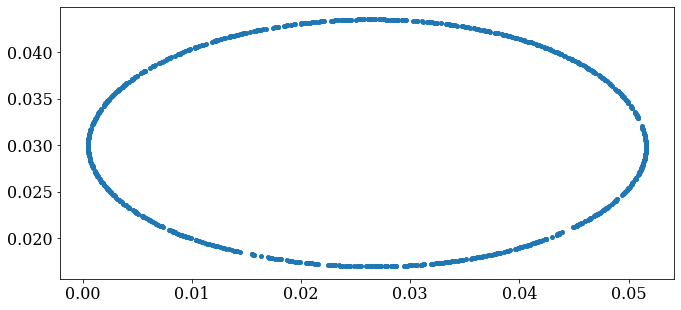

In [78]:
ind_real = np.argpartition((eigvals_h), -2)[-2:]
dve_ans_real = eigvecs_h.T[ind_real]
plt.plot(dve_ans_real[0],dve_ans_real[1] ,'.');

In [86]:
eigvals_1, eigvecs_1 = DVE(X,7)

In [87]:
eigvals_2, eigvecs_2 = DVE(X,10)

In [88]:
eigvals_3, eigvecs_3 = DVE(X,12)

In [89]:
eigvals_4, eigvecs_4 = DVE(X,15)

In [90]:
ind = np.argpartition((eigvals_1), -3)[-3:]
dve_ans_1 = eigvecs_1.T[ind]

ind = np.argpartition((eigvals_4), -3)[-3:]
dve_ans_4 = eigvecs_4.T[ind]

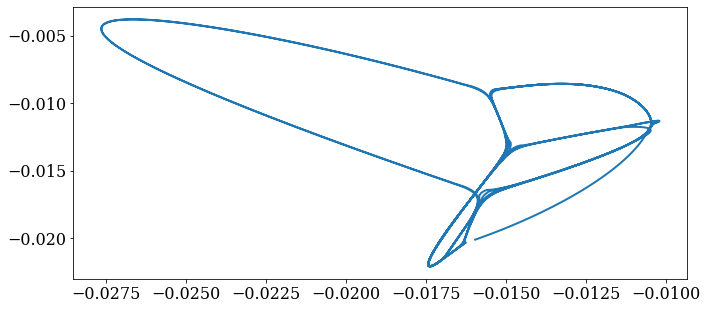

In [83]:
ind = np.argpartition((eigvals_3), -3)[-3:]
dve_ans = eigvecs_3.T[ind]
plt.plot(dve_ans[0],dve_ans[1] ,'-');

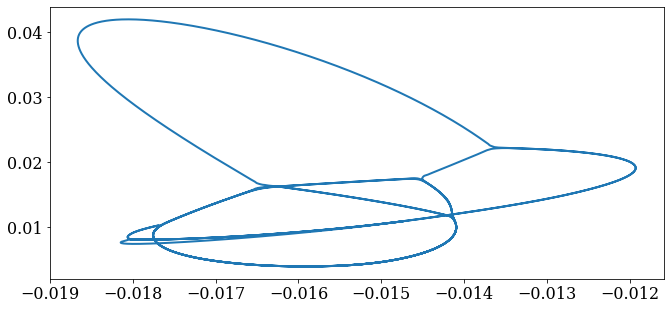

In [75]:
ind_real = np.argpartition((eigvals_real), -3)[-3:]
dve_ans_real = eigvecs_real.T[ind_real]
plt.plot(dve_ans_real[0],dve_ans_real[1] ,'-');

In [91]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2, subplot_titles=('real', 'clear'),
    specs=[[{'type': 'scene'}, {'type': 'scene'}]]
)

fig.add_trace(go.Scatter3d(  x=dve_ans_1[0],
                             y=dve_ans_1[1],
                             z=dve_ans_1[2],
                             marker=dict(size=0.1, line=dict(width=0.01)),
                             name='dve_ans_real'
                            ),
              row = 1, col = 1
                )

fig.add_trace(go.Scatter3d(  x=dve_ans_4[0],
                             y=dve_ans_4[1],
                             z=dve_ans_4[2],
                             marker=dict(size=0.1, line=dict(width=0.01)),
                             name='dve_ans'
                            ),
              row = 1, col = 2
                )


fig.layout.template = 'plotly_white'
fig.update_layout(height=600, width=1000)
fig.show()

In [23]:
fig_2 = go.Figure()


fig_2.add_trace(go.Scatter3d(x=dve_ans[0],
                             y=dve_ans[1],
                             z=dve_ans[2],
                             #mode='markers',
                             marker=dict(size=5,line=dict(width=1)),
                             name='trajectory'
                            )
                )


fig_2.layout.template = 'plotly_white'
fig_2.show()

In [30]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=2, cols=2, subplot_titles=('linear', 'poly', 'rbf', 'sigmoid'),
    specs=[[{'type': 'scene'}, {'type': 'scene'}],
           [{'type': 'scene'}, {'type': 'scene'}]]
)

rc = [[1,1],[1,2],[2,1],[2,2]]

for i, kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
    transformer = KernelPCA(n_components=3, kernel=kernel,gamma = 1/len(X_REAL))

    X_transformed = transformer.fit_transform(X_REAL)

    fig.add_trace(go.Scatter3d(  x=X_transformed[:,0],
                                 y=X_transformed[:,1],
                                 z=X_transformed[:,2],
                                 marker=dict(size=0.1, line=dict(width=0.01)),
                                 #name='trajectory'
                                ),
                  row = rc[i][0], col = rc[i][1]
                    )


fig.layout.template = 'plotly_white'
fig.update_layout(height=1200, width=1000)
fig.show()

In [17]:
Sphere_projection(dve_ans.T)